# Clustering Similar Stocks

In this notebook, we attempt to find similar stocks. A technique such as this would be useful for:

- finding stocks that behave similarly (or dissimilarly) to one of interest
- building trading strategies
- identifying anomalies (e.g. if two stocks are normally correlated but fall out of line in a particular day, you might want to investigate)
- discarding bad stocks (if stocks do not correlate with other stocks they might need investigating).


In [15]:
!pip install s3fs

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - hdbscan


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.4                |   py37hc8dfbb8_2         3.1 MB  conda-forge
    hdbscan-0.8.26             |   py37h03ebfcd_1         668 KB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.7 MB

The following NEW packages will be INSTALLED:

  hdbscan            conda-forge/linux-64::hdbscan-0.8.26-py37h03ebfcd_1
  python_abi         conda-forge/linux-64::python_abi-3.7-1_cp37m


In [17]:
import io
import s3fs
import boto3
import sagemaker
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import hdbscan
import time
import seaborn as sns
import collections
%matplotlib inline
mpl.rcParams['figure.figsize'] = (5, 3) # use bigger graphs
interval = "D"
role = sagemaker.get_execution_role()
session = sagemaker.Session()
s3_data_key = 'sagemaker/stock-prediction/source'
s3_bucket = session.default_bucket()

First we load the data resampled at daily interval, from the S3 bucket location that we saved in the data preparation notebook.

In [18]:
%%time

def date_part(dt):
    return str(dt).split(' ')[0]

def load_resampled_from_s3(interval, bucket, s3_data_key):
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/{}/resampled_stockdata.csv".format(s3_data_key, interval))
    loaded = pd.read_csv(io.BytesIO(obj['Body'].read()), index_col=0, parse_dates=True)
    mnemonics = list(loaded.Mnemonic.unique())   
    unique_days = sorted(list(set(map(date_part , list(loaded.index.unique())))))
    return loaded, mnemonics, unique_days

interval = "D"
stockdata, stocksymbols, unique_days = load_resampled_from_s3(interval, s3_bucket, s3_data_key)

CPU times: user 72.5 ms, sys: 19.7 ms, total: 92.2 ms
Wall time: 211 ms


Also, in order to visualize in the plot with meaningful names for stock symbols, we refer to this list, as provided by Deutsche Borse, that maps the mnemonics to company names.

In [19]:
mnemonic_names = {
    '1COV': 'COVESTRO AG  O.N.',
     '3W9K': '3W POWER S.A. EO -,01',
     'AB1': 'AIR BERLIN PLC    EO -,25',
     'ADS': 'ADIDAS AG NA O.N.',
     'ADV': 'ADVA OPT.NETW.SE  O.N.',
     'AIXA': 'AIXTRON SE NA O.N.',
     'ALV': 'ALLIANZ SE NA O.N.',
     'AOX': 'ALSTRIA OFFICE REIT-AG',
     'ARL': 'AAREAL BANK AG',
     'AT1': 'AROUNDTOWN EO-,01',
     'B4B': 'METRO AG   ST O.N.',
     'BAS': 'BASF SE NA O.N.',
     'BAYN': 'BAYER AG NA O.N.',
     'BEI': 'BEIERSDORF AG O.N.',
     'BMW': 'BAY.MOTOREN WERKE AG ST',
     'BNR': 'BRENNTAG AG NA O.N.',
     'BOSS': 'HUGO BOSS AG NA O.N.',
     'BPE5': 'BP PLC             DL-,25',
     'BVB': 'BORUSSIA DORTMUND',
     'CAP': 'ENCAVIS AG  INH. O.N.',
     'CBK': 'COMMERZBANK AG',
     'CEC': 'CECONOMY AG  ST O.N.',
     'CON': 'CONTINENTAL AG O.N.',
     'DAI': 'DAIMLER AG NA O.N.',
     'DB1': 'DEUTSCHE BOERSE NA O.N.',
     'DBK': 'DEUTSCHE BANK AG NA O.N.',
     'DEQ': 'DEUTSCHE EUROSHOP',
     'DEZ': 'DEUTZ AG O.N.',
     'DHER': 'DELIVERY HERO',
     'DLG': 'DIALOG SEMICOND.   LS-,10',
     'DPW': 'DEUTSCHE POST AG NA O.N.',
     'DRI': '1+1 DRILLISCH AG O.N.',
     'DTE': 'DT.TELEKOM AG NA',
     'DWNI': 'DEUTSCHE WOHNEN SE INH',
     'EOAN': 'E.ON SE NA O.N.',
     'EVK': 'EVONIK INDUSTRIES NA O.N.',
     'EVT': 'EVOTEC AG O.N.',
     'FME': 'FRESEN.MED.CARE KGAA O.N.',
     'FNTN': 'FREENET AG NA O.N.',
     'FRE': 'FRESENIUS SE+CO.KGAA O.N.',
     'G1A': 'GEA GROUP AG',
     'GAZ': 'GAZPROM ADR SP./2 RL 5L 5',
     'GYC': 'GRAND CITY PROPERT.EO-,10',
     'HDD': 'HEIDELBERG.DRUCKMA.O.N.',
     'HEI': 'HEIDELBERGCEMENT AG O.N.',
     'HEN3': 'HENKEL AG+CO.KGAA VZO',
     'IFX': 'INFINEON TECH.AG NA O.N.',
     'IGY': 'INNOGY SE  INH. O.N.',
     'KCO': 'KLOECKNER + CO SE NA O.N.',
     'KGX': 'KION GROUP AG',
     'LEO': 'DREYFUS STRATEGIC MUNI',
     'LHA': ',LUFTHANSA AG VNA O.N.',
     'LIN': 'LINDE AG O.N.',
     'LINU': 'LINDE AG O.N. Z.UMT.',
     'LLD': 'LLOYDS BKG GRP     LS-,10',
     'LXS': 'LANXESS AG',
     'MDG1': 'MEDIGENE AG NA O.N.',
     'MRK': 'MERCK KGAA O.N.',
     'MUV2': 'MUENCH.RUECKVERS.VNA O.N.',
     'NDA': 'AURUBIS AG',
     'NDX1': 'NORDEX SE O.N.',
     'NOA3': 'NOKIA OYJ EO-,06',
     'O2D': 'TELEFONICA DTLD HLDG NA',
     'OSR': 'OSRAM LICHT AG NA O.N.',
     'PAH3': 'PORSCHE AUTOM.HLDG VZO',
     'PBB': 'DT.PFANDBRIEFBK AG',
     'PNE3': 'PNE WIND AG NA O.N.',
     'PSM': 'PROSIEBENSAT.1  NA O.N.',
     'QIA': 'QIAGEN NV         EO -,01',
     'QSC': 'QSC AG NA O.N.',
     'RIB': 'RIB SOFTWARE SE  NA EO 1',
     'RKET': 'ROCKET INTERNET SE',
     'RWE': 'RWE AG ST O.N.',
     'SANT': 'S+T AG (Z.REG.MK.Z.)O.N.',
     'SAP': 'SAP SE O.N.',
     'SDF': 'K+S AG NA O.N.',
     'SGL': 'SGL CARBON SE O.N.',
     'SHA': 'SCHAEFFLER AG INH. VZO',
     'SHL': 'SIEMENS HEALTH.AG NA O.N.',
     'SIE': 'SIEMENS AG NA',
     'SNH': 'STEINHOFF INT.HLDG.EO-,50',
     'SOW': 'SOFTWARE AG  NA O.N.',
     'SVAB': 'STOCKHOLM IT VENTURES AB',
     'SY1': 'SYMRISE AG INH. O.N.',
     'SZG': 'SALZGITTER AG O.N.',
     'SZU': 'SUEDZUCKER AG  O.N.',
     'TC1': 'TELE COLUMBUS',
     'TEG': 'TAG IMMOBILIEN AG',
     'TKA': 'THYSSENKRUPP AG O.N.',
     'TTI': 'TOM TAILOR HLDG  NA O.N.',
     'TUI1': 'TUI AG NA O.N.',
     'UN01': 'UNIPER SE  NA O.N.',
     'USE': 'BEATE UHSE AG',
     'UTDI': 'UTD.INTERNET AG NA',
     'VNA': 'VONOVIA SE NA O.N.',
     'VODI': 'VODAFONE GROUP PLC',
     'VOW3': 'VOLKSWAGEN AG VZO O.N.',
     'WAF': 'SILTRONIC AG NA O.N.',
     'WDI': 'WIRECARD AG',
     'ZAL': 'ZALANDO SE',
     'ZIL2': 'ELRINGKLINGER AG NA O.N.',
     'TINA': 'TINA',
     'ANO': 'ANO',
     'ARO': 'ARO'                   
}

## Methodology

1. Select a time frame within which to analyze the stocks (e.g. 60 days).
- Select an interval within which to aggregate the prices (e.g. 1 day).
- Select a function of the price such as percent change or log returns.
- Select a similarity function between the timeseries, such as dot product, cosine or correlation coefficient.
- Select a clustering algorithm.
- Visualize the results.

In [20]:
def prepare_single_stock(df, mnemonic, interval):
    single_stock = df[df.Mnemonic == mnemonic].copy()
    single_stock['Avg4Price'] = 0.25*(single_stock['MaxPrice'] + single_stock['MinPrice'] + 
                                      single_stock['StartPrice'] + single_stock['EndPrice'])
    
    resampled = pd.DataFrame({
        'MeanAvg4Price': single_stock['Avg4Price'].resample(interval).mean(),          
        'Mnemonic': mnemonic,
    })
    resampled['PctChange'] = resampled['MeanAvg4Price'].pct_change().fillna(0.0)
    return resampled[['Mnemonic', 'PctChange', 'MeanAvg4Price']]

selected_days = unique_days[0:60]
subset_df = stockdata[stockdata.index.isin(list(selected_days))]
mnemonics = subset_df['Mnemonic'].unique()

In [21]:
single_stocks_dfs = []

interval = 'D'

for mnemonic in mnemonics:
    single_stock = prepare_single_stock(subset_df, mnemonic, interval)
    single_stocks_dfs.append(single_stock)

# the dataframe for clustering    
clustering_df = pd.concat(single_stocks_dfs, axis=0)
clustering_df['CalcDateTime'] = clustering_df.index

In [22]:
cluster_by_feature = 'PctChange' 
subset = clustering_df.pivot(index='CalcDateTime', columns='Mnemonic', values=cluster_by_feature)
corr_mat = subset.corr().fillna(0.0)

In [23]:
def find_most_correlated(corr_mat, mnemonic, n=5):
    results = corr_mat[[mnemonic]].sort_values(mnemonic, ascending=False).head(n).copy()

    results['Desc'] = list(map(lambda m: mnemonic_names[m], list(results.index)))

    results['Corr'] = results[mnemonic]
    
    return results[['Desc', 'Corr']]

find_most_correlated(corr_mat, 'VOW3')

Mnemonic,Desc,Corr
Mnemonic,,
VOW3,VOLKSWAGEN AG VZO O.N.,1.000000
PAH3,PORSCHE AUTOM.HLDG VZO,0.934305
DAI,DAIMLER AG NA O.N.,0.766545
BMW,BAY.MOTOREN WERKE AG ST,0.764533
CON,CONTINENTAL AG O.N.,0.546863


In [25]:
class Cluster:
    def __init__(self, cluster_id, members):
        self.cluster_id = cluster_id
        self.members = members
        
    def __repr__(self):
        printstr = "\nCluster {}:".format(self.cluster_id+2)
        for mem in self.members:
            printstr = printstr + "\n\t{}".format(mem)
        return  printstr
        
def build_clusters(data, algorithm, args, kwds, names):
    membership_labels = algorithm(*args, **kwds).fit_predict(data)
    d = collections.defaultdict(list)
    i = 0
    for label in membership_labels:
        d[label].append(names[i])
        i += 1
    clusters = []
    for k,v in d.items():
        clusters.append(Cluster(k, v))
    clusters.sort(key=lambda x: x.cluster_id)

    return membership_labels, clusters


friendly_labels = []

def truncate_str(v):
    t = 12
    if len(v) <= t:
        return v
    return v[0:10] + "..."

for m in list(corr_mat.index):
    friendly_labels.append("{}({})".format(m, mnemonic_names.get(m, None)))

membership_labels, clusters = build_clusters(corr_mat, hdbscan.HDBSCAN, (), {'min_cluster_size':2}, friendly_labels)
print(clusters)

[
Cluster 1:
	1COV(COVESTRO AG  O.N.)
	ADS(ADIDAS AG NA O.N.)
	AT1(AROUNDTOWN EO-,01)
	B4B(METRO AG   ST O.N.)
	BAYN(BAYER AG NA O.N.)
	BNR(BRENNTAG AG NA O.N.)
	BOSS(HUGO BOSS AG NA O.N.)
	CEC(CECONOMY AG  ST O.N.)
	DB1(DEUTSCHE BOERSE NA O.N.)
	DEZ(DEUTZ AG O.N.)
	DRI(1+1 DRILLISCH AG O.N.)
	HEN3(HENKEL AG+CO.KGAA VZO)
	KCO(KLOECKNER + CO SE NA O.N.)
	KGX(KION GROUP AG)
	LEO(DREYFUS STRATEGIC MUNI)
	LHA(,LUFTHANSA AG VNA O.N.)
	LINU(LINDE AG O.N. Z.UMT.)
	MDG1(MEDIGENE AG NA O.N.)
	MRK(MERCK KGAA O.N.)
	NDA(AURUBIS AG)
	NDX1(NORDEX SE O.N.)
	PNE3(PNE WIND AG NA O.N.)
	RIB(RIB SOFTWARE SE  NA EO 1)
	RKET(ROCKET INTERNET SE)
	SGL(SGL CARBON SE O.N.)
	SNH(STEINHOFF INT.HLDG.EO-,50)
	TC1(TELE COLUMBUS)
	TINA(TINA)
	TUI1(TUI AG NA O.N.)
	WAF(SILTRONIC AG NA O.N.), 
Cluster 2:
	AB1(AIR BERLIN PLC    EO -,25)
	SVAB(STOCKHOLM IT VENTURES AB)
	USE(BEATE UHSE AG), 
Cluster 3:
	DHER(DELIVERY HERO)
	ZIL2(ELRINGKLINGER AG NA O.N.), 
Cluster 4:
	EVT(EVOTEC AG O.N.)
	HDD(HEIDELBERG.DRUCKMA.O.N.)
	T

Although the result of clustering depends on the time period in which the clustering was done, the discretization interval and similarity function chosen, in general you should see somewhat similar stocks clustered together.

For example, automobile companies such as these are cluetered together:

    BMW (BMW)
    Daimler (DAI)
    Porshe (PAH3)
    Continental (CON)
    Volkswagen (VOW3)

Also telecommunication companies are clutered together:

    Nokia (NOA3)
    Vodafone (VODI)
    Telefonica (O2D)
    Deutche Telecom (DTE)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 99 samples in 0.000s...
[t-SNE] Computed neighbors for 99 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 99 / 99
[t-SNE] Mean sigma: 0.763534
[t-SNE] Computed conditional probabilities in 0.006s
[t-SNE] Iteration 50: error = 58.6308746, gradient norm = 0.4958538 (50 iterations in 0.032s)
[t-SNE] Iteration 100: error = 57.0632782, gradient norm = 0.5308305 (50 iterations in 0.038s)
[t-SNE] Iteration 150: error = 57.5806274, gradient norm = 0.4998307 (50 iterations in 0.035s)
[t-SNE] Iteration 200: error = 58.8316078, gradient norm = 0.5081700 (50 iterations in 0.033s)
[t-SNE] Iteration 250: error = 58.3492851, gradient norm = 0.5428327 (50 iterations in 0.037s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.349285
[t-SNE] Iteration 300: error = 1.0261674, gradient norm = 0.0081228 (50 iterations in 0.039s)
[t-SNE] Iteration 350: error = 0.8447487, gradient norm = 0.0029362 (50 i

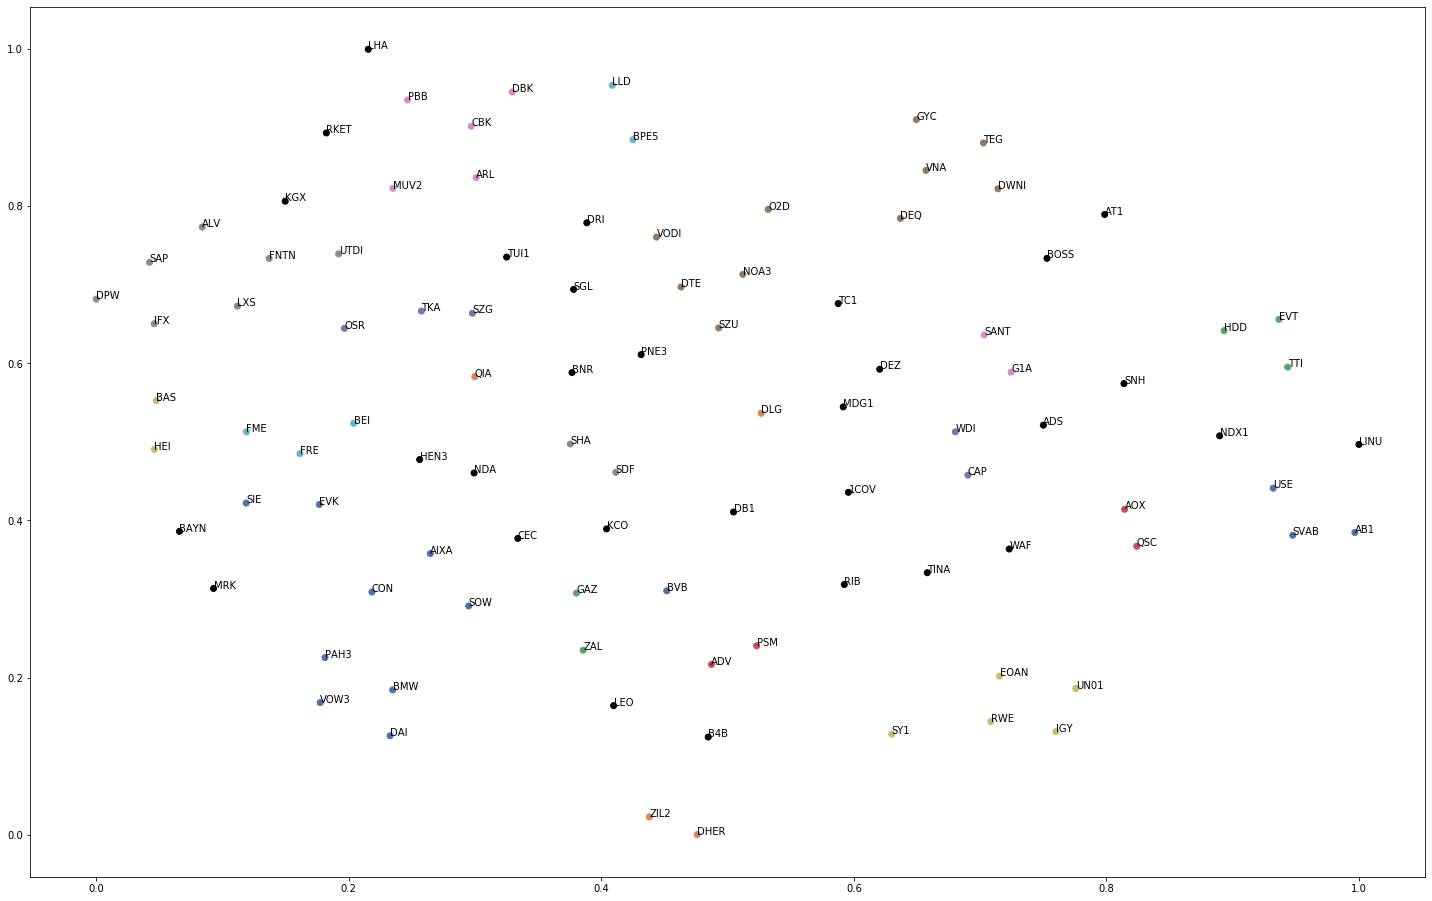

In [26]:
mpl.rcParams['figure.figsize'] = (25, 16) # use bigger graphs

model = TSNE(n_components=2, perplexity=25, verbose=2, random_state=686861).fit_transform(corr_mat)

x_axis=model[:,0]
y_axis=model[:,1]
x_norm = (x_axis-np.min(x_axis)) / (np.max(x_axis) - np.min(x_axis))
y_norm = (y_axis-np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))

fig, ax = plt.subplots()
palette = sns.color_palette('deep', np.unique(membership_labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in membership_labels]
    
ax.scatter(x_norm, y_norm, c = colors)
top = corr_mat.head(100)
names = list(top.index) 

for m in names:
    ax.annotate(m, (x_norm[names.index(m)],y_norm[names.index(m)]))    
    
    
#fig.savefig('stockclusters.png')

Symbols plotted graphically visually depicts, where you can find some of the prominent clusters, as described above.